## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dirty_completeness

## Useful Functions

In [2]:
def hists_plot(df):
    fig, axes = plt.subplots(1, len(df.columns), figsize=(20,5))
    ax = axes.flatten()
    for i, col in enumerate(df.columns):
        sns.countplot(df, x=col, ax=axes[i], order=sorted(df[col].value_counts().index))

In [3]:
def accuracy(df, df_imputed):
    accuracy = {}
    for col in df.columns:
        equal = np.where(df[col] == df_imputed[col], True, False)
        accuracy[col] = equal[equal == True].sum() / len(equal)
    return accuracy

In [4]:
def jaccard_dist(a,b):
    intersction =len(set(a).intersection(b))
    union = len(a) + len(b) -intersction
    return 1 - float(intersction) / union

## Read data

In [5]:
users = pd.read_csv('users.csv')

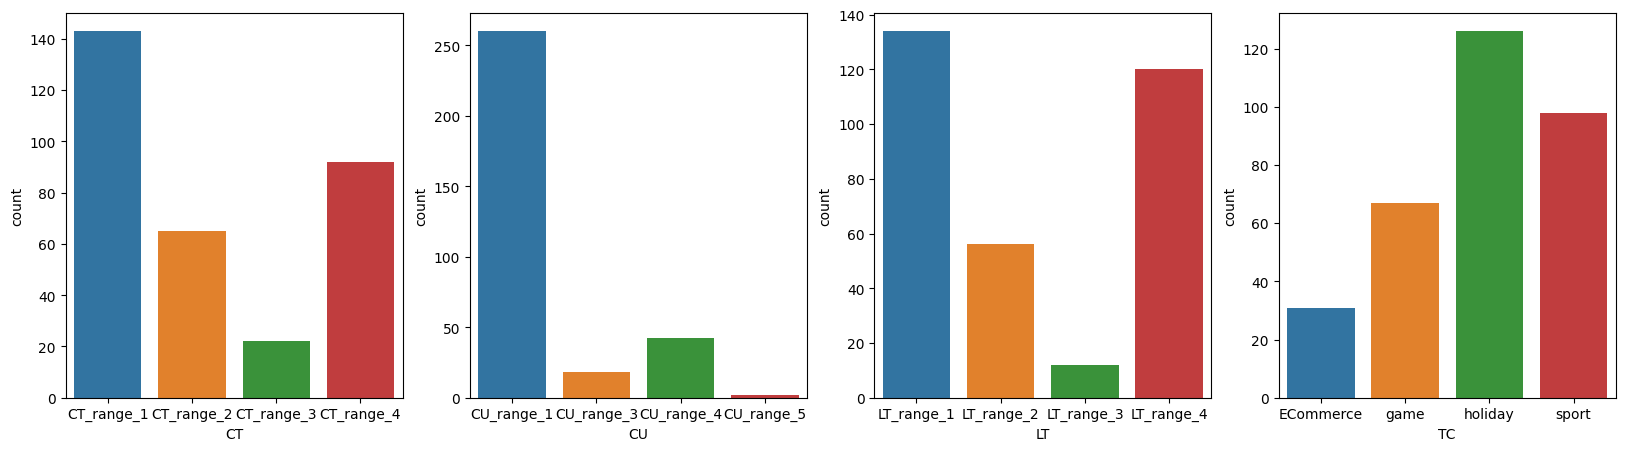

In [6]:
hists_plot(users)

## Shuffle data

In [7]:
users = users.sample(frac=1, axis=0).reset_index(drop=True)

## Inject null values

In [8]:
users_dirty = np.array(dirty_completeness.injection(df_pandas=users, seed=1234, name = 'users', name_class="none"))

saved users-completeness50%
saved users-completeness60%
saved users-completeness70%
saved users-completeness80%
saved users-completeness90%


In [9]:
users_dirty = users_dirty[0,:,:] #50% completeness

In [10]:
users_dirty = pd.DataFrame(users_dirty,columns=users.columns)

In [11]:
users_dirty

,CT,CU,LT,TC
0,NaN,CU_range_1,NaN,NaN
1,CT_range_3,CU_range_1,LT_range_4,sport
2,NaN,CU_range_3,NaN,sport
3,CT_range_2,NaN,NaN,holiday
4,CT_range_4,CU_range_1,LT_range_1,NaN
...,...,...,...,...
317,CT_range_2,NaN,LT_range_4,sport
318,CT_range_3,NaN,NaN,NaN
319,CT_range_1,NaN,LT_range_4,ECommerce
320,CT_range_1,CU_range_4,LT_range_1,NaN


## Visualizing null values

<AxesSubplot:>

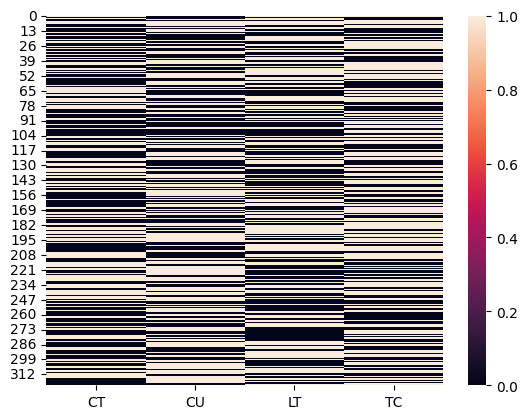

In [12]:
sns.heatmap(users_dirty.isna())

## Imputation

### Simple Imputation FFILL&BFILL

In [13]:
users_simple_imp = users_dirty.fillna(method='ffill')
users_simple_imp.isna().count()
users_simple_imp = users_simple_imp.fillna(method='bfill')

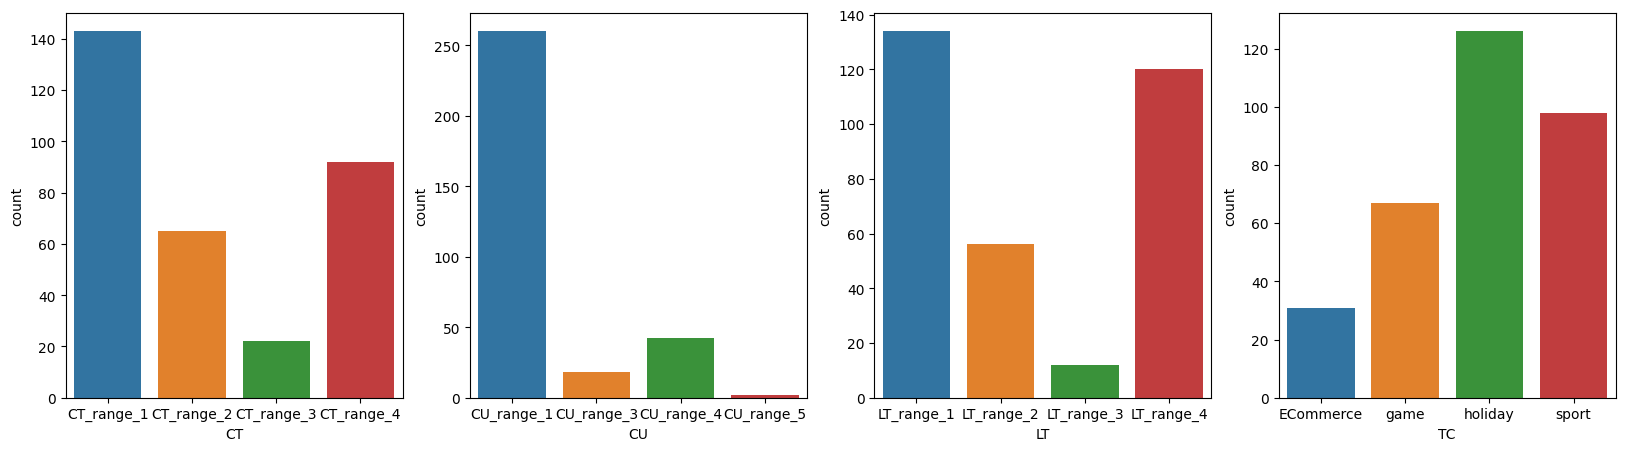

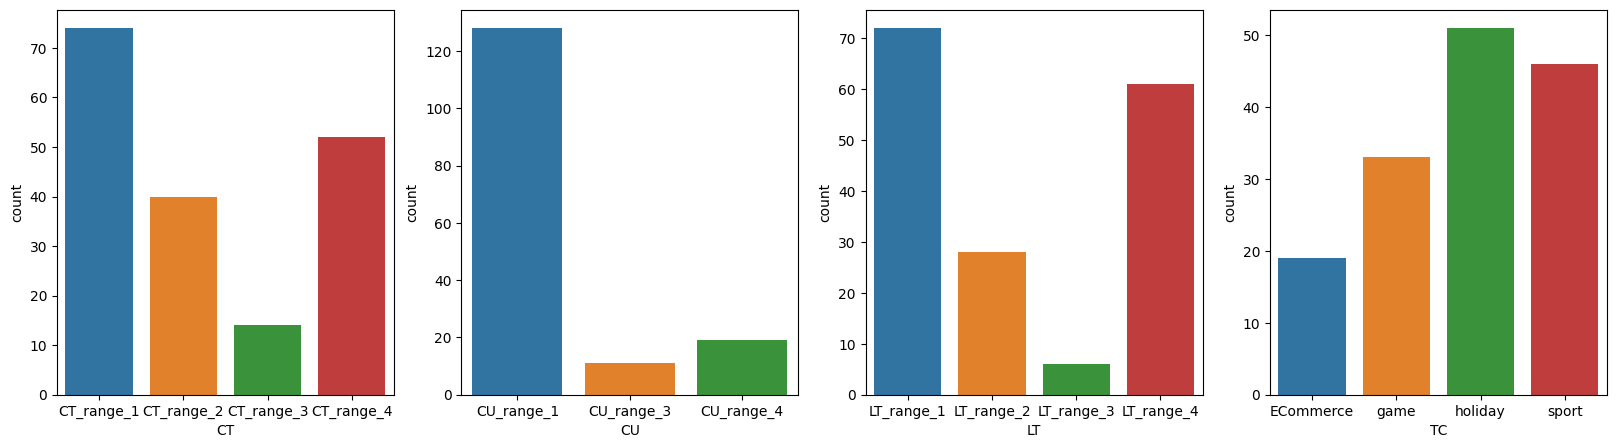

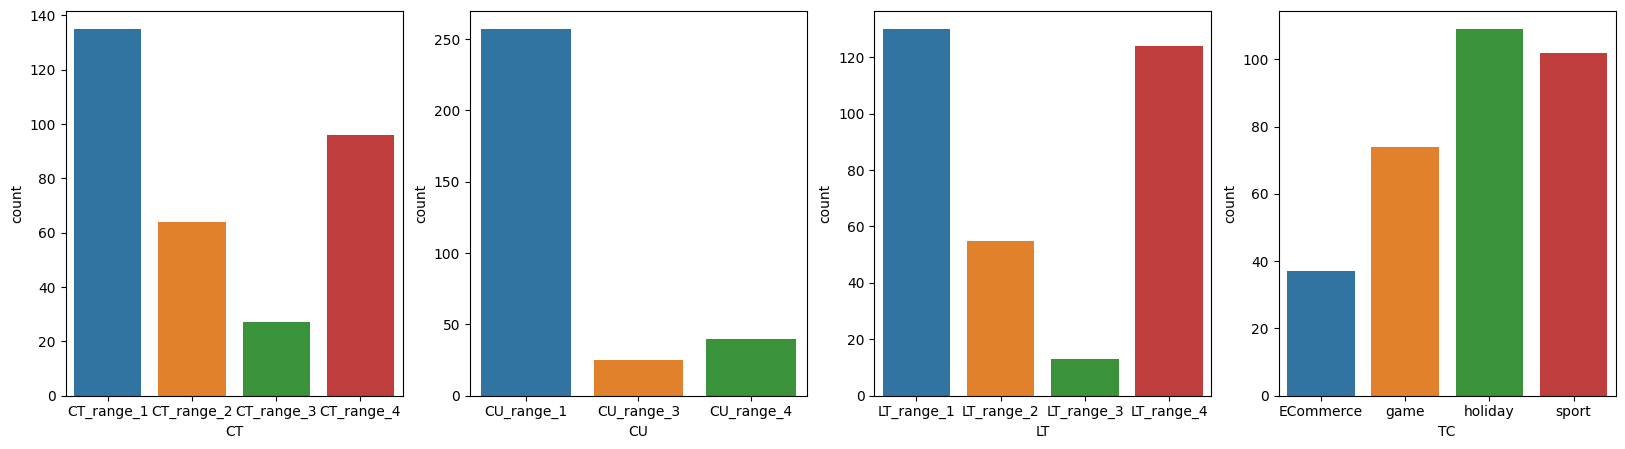

In [14]:
hists_plot(users)
hists_plot(users_dirty)
hists_plot(users_simple_imp)

In [15]:
accuracy(users, users_simple_imp)

{'CT': 0.7298136645962733,
 'CU': 0.8291925465838509,
 'LT': 0.6832298136645962,
 'TC': 0.5900621118012422}

### Advanced Imputation: KNN

In [16]:
users_dirty_one_hot = pd.get_dummies(users_dirty)
for col in users_dirty.columns:
    users_dirty_one_hot.loc[users_dirty[col].isnull(), users_dirty_one_hot.columns.str.startswith(col)] = np.nan

In [17]:
from sklearn.impute import KNNImputer

In [18]:
knn_imputer = KNNImputer(n_neighbors=4)
users_knn_imp_one_hot = pd.DataFrame(knn_imputer.fit_transform(users_dirty_one_hot))
users_knn_imp_one_hot.columns = users_dirty_one_hot.columns

In [19]:
users_knn_imp = pd.DataFrame()
for col in users_dirty.columns:
   users_knn_imp[col] = users_knn_imp_one_hot.loc[:, users_knn_imp_one_hot.columns.str.startswith(col)].idxmax(1)
users_knn_imp = users_knn_imp.apply(lambda e: e.str[3:] )

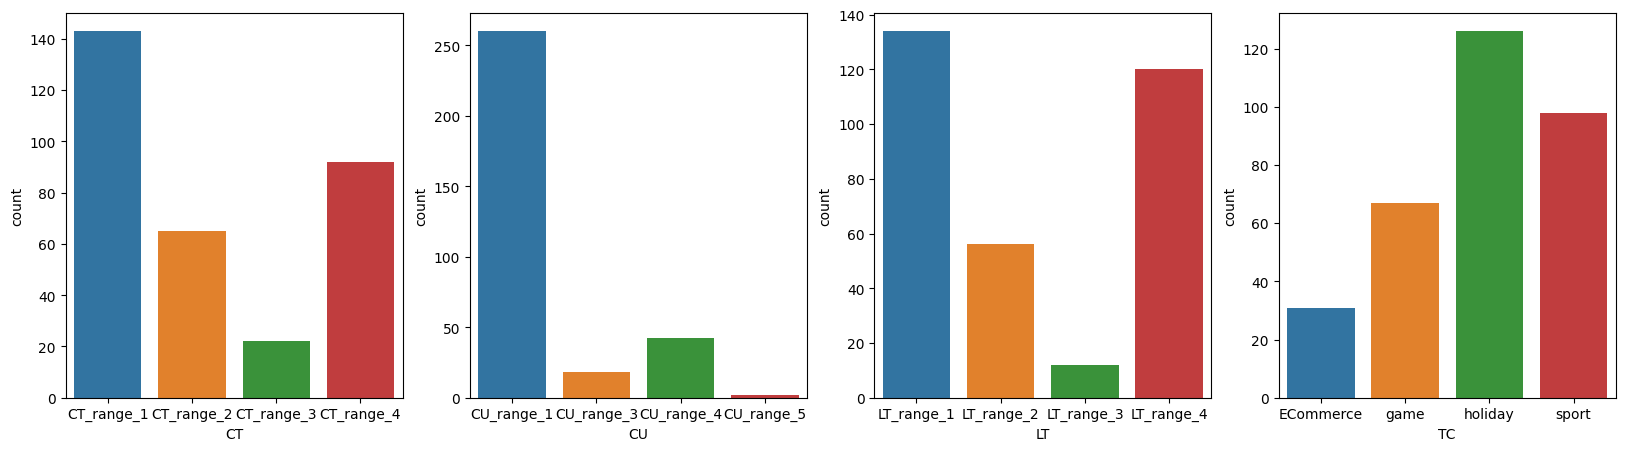

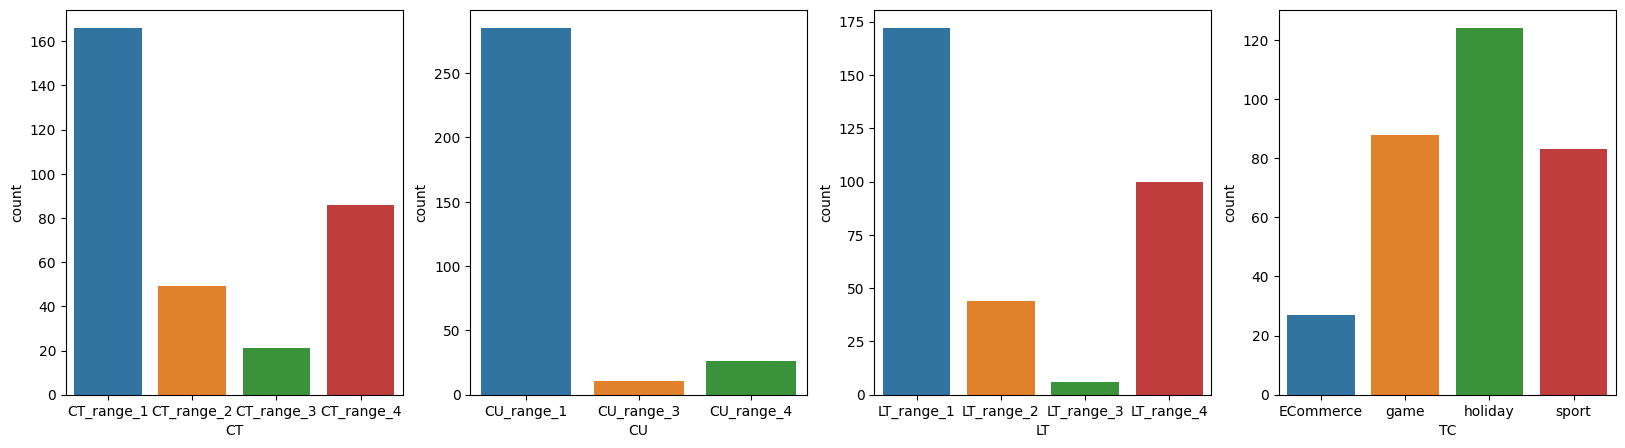

In [20]:
hists_plot(users)
hists_plot(users_knn_imp)

In [21]:
accuracy(users,users_knn_imp)

{'CT': 0.7732919254658385,
 'CU': 0.922360248447205,
 'LT': 0.8074534161490683,
 'TC': 0.8074534161490683}

## Clustering

### 1. K-Modes

In [22]:
%pip install kmodes

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [23]:
from kmodes.kmodes import KModes

In [24]:
# Elbow curve to find optimal K
def elbow(df, k_max=16):
    cost = []
    K = range(1,k_max)
    for num_clusters in list(K):
        kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=0)
        kmode.fit_predict(df)
        cost.append(kmode.cost_)
        
    plt.plot(K, cost, 'bx-')
    plt.xlabel('No. of clusters')
    plt.ylabel('Cost')
    plt.title('Elbow Method For Optimal k')


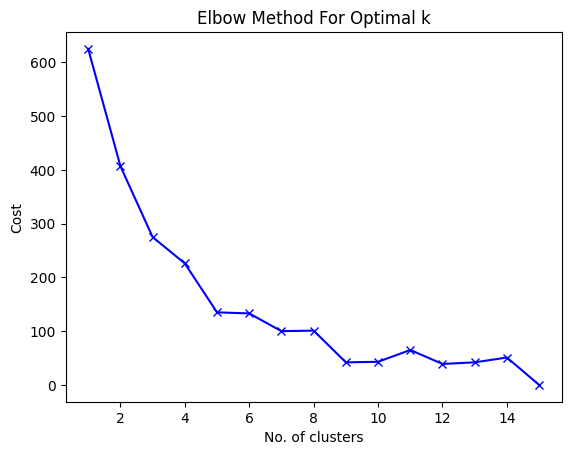

In [25]:
elbow(users)

According to the elbow plot we get the optimal number of cluster k=5

In [26]:
kmodes = KModes(n_jobs = -1, n_clusters = 5, init = 'random', random_state = 0)
kmodes.fit_predict(users_knn_imp)

array([0, 3, 3, 1, 0, 2, 2, 0, 3, 2, 2, 0, 2, 2, 4, 0, 0, 0, 2, 2, 2, 3,
       0, 4, 0, 0, 2, 3, 2, 2, 4, 2, 0, 0, 2, 3, 0, 4, 4, 2, 2, 2, 0, 1,
       1, 0, 0, 4, 0, 0, 3, 0, 3, 2, 4, 2, 4, 1, 4, 3, 0, 0, 1, 3, 2, 1,
       3, 2, 0, 2, 3, 2, 0, 0, 2, 2, 2, 1, 0, 2, 2, 2, 2, 4, 3, 3, 1, 3,
       2, 3, 0, 3, 0, 0, 3, 1, 2, 1, 2, 0, 0, 1, 2, 3, 3, 0, 0, 1, 3, 2,
       0, 2, 2, 1, 0, 2, 0, 3, 0, 1, 3, 1, 1, 3, 2, 1, 0, 4, 3, 2, 0, 3,
       1, 2, 3, 1, 0, 0, 2, 0, 2, 2, 3, 0, 3, 3, 3, 2, 1, 0, 2, 0, 3, 3,
       3, 0, 3, 4, 3, 4, 3, 0, 3, 0, 0, 1, 2, 0, 0, 2, 1, 0, 2, 2, 0, 0,
       3, 1, 0, 0, 0, 3, 0, 2, 2, 0, 4, 0, 2, 4, 0, 2, 2, 2, 2, 2, 0, 0,
       4, 3, 2, 1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 3, 4, 2, 3, 4, 3, 2, 0,
       3, 2, 3, 0, 2, 3, 2, 3, 2, 2, 3, 3, 1, 1, 0, 4, 4, 1, 1, 3, 0, 2,
       2, 2, 0, 3, 2, 2, 1, 2, 2, 1, 0, 3, 2, 2, 1, 2, 0, 2, 0, 1, 0, 3,
       0, 1, 3, 1, 3, 2, 0, 3, 3, 3, 1, 2, 1, 3, 0, 1, 2, 0, 0, 0, 0, 2,
       0, 1, 2, 0, 3, 1, 2, 1, 3, 0, 0, 2, 4, 0, 2,

#### Cluster Personas

In [104]:
print(kmodes.cluster_centroids_)

[['CT_range_4' 'CU_range_1' 'LT_range_1' 'game']
 ['CT_range_2' 'CU_range_1' 'LT_range_2' 'holiday']
 ['CT_range_1' 'CU_range_1' 'LT_range_1' 'holiday']
 ['CT_range_1' 'CU_range_1' 'LT_range_4' 'sport']
 ['CT_range_1' 'CU_range_4' 'LT_range_1' 'ECommerce']]


In [28]:
users_cluster_kmodes = pd.DataFrame.copy(users)
users_cluster_kmodes['Cluster'] = kmodes.labels_

In [29]:
users_cluster_kmodes

,CT,CU,LT,TC,Cluster
0,CT_range_1,CU_range_1,LT_range_1,holiday,0
1,CT_range_3,CU_range_1,LT_range_4,sport,3
2,CT_range_1,CU_range_3,LT_range_4,sport,3
3,CT_range_2,CU_range_1,LT_range_2,holiday,1
4,CT_range_4,CU_range_1,LT_range_1,game,0
...,...,...,...,...,...
317,CT_range_2,CU_range_1,LT_range_4,sport,3
318,CT_range_3,CU_range_1,LT_range_4,sport,3
319,CT_range_1,CU_range_4,LT_range_4,ECommerce,3
320,CT_range_1,CU_range_4,LT_range_1,ECommerce,4


### 2. Agglomerative Hierarchical Clustering

In [30]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score

#### Compute the distance matrix using Jaccard Distance

In [31]:
dist_matrix = np.asarray( [[jaccard_dist(a,b) for _,b in users.iterrows()] for _,a in users.iterrows()])

In [32]:
pd.DataFrame(dist_matrix)

,0,1,2,3,4,5,6,7,8,9,...,312,313,314,315,316,317,318,319,320,321
0,0.000000,0.857143,0.857143,0.666667,0.666667,0.666667,0.857143,0.857143,0.857143,0.000000,...,0.857143,0.000000,0.000000,0.857143,0.857143,0.857143,0.857143,0.857143,0.666667,0.000000
1,0.857143,0.000000,0.666667,0.857143,0.857143,0.857143,0.857143,0.666667,0.666667,0.857143,...,0.857143,0.857143,0.857143,0.666667,0.857143,0.400000,0.000000,0.857143,1.000000,0.857143
2,0.857143,0.666667,0.000000,1.000000,1.000000,1.000000,0.666667,0.857143,0.000000,0.857143,...,1.000000,0.857143,0.857143,0.400000,0.666667,0.666667,0.666667,0.666667,0.857143,0.857143
3,0.666667,0.857143,1.000000,0.000000,0.857143,0.857143,1.000000,0.857143,1.000000,0.666667,...,0.666667,0.666667,0.666667,1.000000,1.000000,0.666667,0.857143,1.000000,1.000000,0.666667
4,0.666667,0.857143,1.000000,0.857143,0.000000,0.000000,1.000000,0.400000,1.000000,0.666667,...,0.400000,0.666667,0.666667,1.000000,1.000000,0.857143,0.857143,1.000000,0.857143,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,0.857143,0.400000,0.666667,0.666667,0.857143,0.857143,0.857143,0.666667,0.666667,0.857143,...,0.857143,0.857143,0.857143,0.666667,0.857143,0.000000,0.400000,0.857143,1.000000,0.857143
318,0.857143,0.000000,0.666667,0.857143,0.857143,0.857143,0.857143,0.666667,0.666667,0.857143,...,0.857143,0.857143,0.857143,0.666667,0.857143,0.400000,0.000000,0.857143,1.000000,0.857143
319,0.857143,0.857143,0.666667,1.000000,1.000000,1.000000,0.000000,0.857143,0.666667,0.857143,...,1.000000,0.857143,0.857143,0.400000,0.400000,0.857143,0.857143,0.000000,0.400000,0.857143
320,0.666667,1.000000,0.857143,1.000000,0.857143,0.857143,0.400000,1.000000,0.857143,0.666667,...,1.000000,0.666667,0.666667,0.666667,0.666667,1.000000,1.000000,0.400000,0.000000,0.666667


#### Perform the Agglomerative Clustering

In [33]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(20,5))
    plt.title("Hierarchical Clustering Dendrogram")
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

In [34]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='precomputed',linkage='complete').fit(dist_matrix)

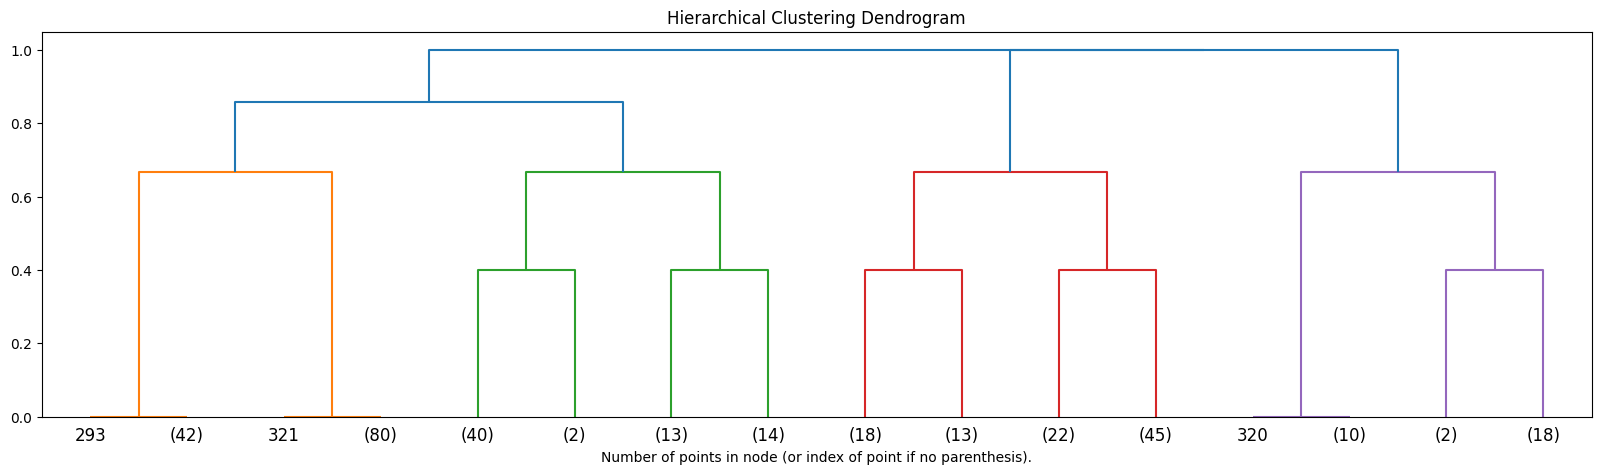

In [35]:
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode="level", p=3)

In [95]:
agglomerative = AgglomerativeClustering(n_clusters=5, affinity='precomputed',linkage='complete').fit(dist_matrix)


In [96]:
users_cluster_agglomerative = pd.DataFrame.copy(users)
users_cluster_agglomerative['Cluster'] = agglomerative.labels_
users_cluster_agglomerative

,CT,CU,LT,TC,Cluster
0,CT_range_1,CU_range_1,LT_range_1,holiday,3
1,CT_range_3,CU_range_1,LT_range_4,sport,0
2,CT_range_1,CU_range_3,LT_range_4,sport,0
3,CT_range_2,CU_range_1,LT_range_2,holiday,3
4,CT_range_4,CU_range_1,LT_range_1,game,1
...,...,...,...,...,...
317,CT_range_2,CU_range_1,LT_range_4,sport,0
318,CT_range_3,CU_range_1,LT_range_4,sport,0
319,CT_range_1,CU_range_4,LT_range_4,ECommerce,2
320,CT_range_1,CU_range_4,LT_range_1,ECommerce,4


#### Cluster Personas

In [97]:
users_cluster_agglomerative.groupby(['Cluster']).agg(pd.Series.mode)

,CT,CU,LT,TC
Cluster,,,,
0,CT_range_1,CU_range_1,LT_range_4,sport
1,CT_range_4,CU_range_1,LT_range_1,game
2,CT_range_1,CU_range_4,LT_range_4,ECommerce
3,CT_range_1,CU_range_1,LT_range_1,holiday
4,CT_range_1,CU_range_4,LT_range_1,ECommerce


In [98]:
silhouette_score(dist_matrix, agglomerative.labels_)

0.5435398550152514

In [92]:
clusterss = users.groupby(['CT','CU','LT','TC']).size().reset_index(name='Count')#.iloc[:,:-1]
clusterss

,CT,CU,LT,TC,Count
0,CT_range_1,CU_range_1,LT_range_1,holiday,81
1,CT_range_1,CU_range_3,LT_range_4,sport,18
2,CT_range_1,CU_range_4,LT_range_1,ECommerce,11
3,CT_range_1,CU_range_4,LT_range_4,ECommerce,18
4,CT_range_1,CU_range_4,LT_range_4,sport,13
5,CT_range_1,CU_range_5,LT_range_4,ECommerce,2
6,CT_range_2,CU_range_1,LT_range_2,holiday,43
7,CT_range_2,CU_range_1,LT_range_4,sport,22
8,CT_range_3,CU_range_1,LT_range_4,sport,22
9,CT_range_4,CU_range_1,LT_range_1,game,40


In [93]:
dist_matrix2 = np.asarray( [[jaccard_dist(a,b) for _,b in clusterss.iterrows()] for _,a in clusterss.iterrows()])

In [94]:
pd.DataFrame(dist_matrix2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.888889,0.750000,0.888889,0.888889,0.888889,0.750000,0.888889,0.888889,0.750000,0.571429,0.888889,0.888889,0.888889,0.888889
1,0.888889,0.000000,0.888889,0.571429,0.571429,0.750000,1.000000,0.750000,0.750000,1.000000,1.000000,1.000000,1.000000,0.888889,0.750000
2,0.750000,0.888889,0.000000,0.571429,0.750000,0.750000,1.000000,1.000000,1.000000,0.888889,0.888889,1.000000,1.000000,1.000000,1.000000
3,0.888889,0.571429,0.571429,0.000000,0.571429,0.571429,1.000000,0.888889,0.888889,1.000000,1.000000,1.000000,1.000000,0.888889,0.888889
4,0.888889,0.571429,0.750000,0.571429,0.000000,0.750000,1.000000,0.750000,0.750000,1.000000,1.000000,0.888889,1.000000,0.888889,0.750000
5,0.888889,0.750000,0.750000,0.571429,0.750000,0.000000,1.000000,0.888889,0.888889,1.000000,0.888889,1.000000,1.000000,0.750000,0.888889
6,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.750000,0.888889,0.888889,0.750000,0.750000,0.888889,0.888889,0.888889
7,0.888889,0.750000,1.000000,0.888889,0.750000,0.888889,0.750000,0.000000,0.333333,0.888889,0.888889,0.888889,0.888889,0.750000,0.571429
8,0.888889,0.750000,1.000000,0.888889,0.750000,0.888889,0.888889,0.333333,0.000000,0.888889,0.888889,0.888889,0.888889,0.750000,0.571429
9,0.750000,1.000000,0.888889,1.000000,1.000000,1.000000,0.888889,0.888889,0.888889,0.000000,0.571429,0.571429,0.571429,0.571429,0.750000


In [45]:
%pip install gower

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [51]:
import gower
from sklearn.cluster import KMeans

In [47]:
distance_matrix = gower.gower_matrix(users)

In [50]:
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9,...,312,313,314,315,316,317,318,319,320,321
0,0.00,0.75,0.75,0.50,0.50,0.50,0.75,0.75,0.75,0.00,...,0.75,0.00,0.00,0.75,0.75,0.75,0.75,0.75,0.50,0.00
1,0.75,0.00,0.50,0.75,0.75,0.75,0.75,0.50,0.50,0.75,...,0.75,0.75,0.75,0.50,0.75,0.25,0.00,0.75,1.00,0.75
2,0.75,0.50,0.00,1.00,1.00,1.00,0.50,0.75,0.00,0.75,...,1.00,0.75,0.75,0.25,0.50,0.50,0.50,0.50,0.75,0.75
3,0.50,0.75,1.00,0.00,0.75,0.75,1.00,0.75,1.00,0.50,...,0.50,0.50,0.50,1.00,1.00,0.50,0.75,1.00,1.00,0.50
4,0.50,0.75,1.00,0.75,0.00,0.00,1.00,0.25,1.00,0.50,...,0.25,0.50,0.50,1.00,1.00,0.75,0.75,1.00,0.75,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,0.75,0.25,0.50,0.50,0.75,0.75,0.75,0.50,0.50,0.75,...,0.75,0.75,0.75,0.50,0.75,0.00,0.25,0.75,1.00,0.75
318,0.75,0.00,0.50,0.75,0.75,0.75,0.75,0.50,0.50,0.75,...,0.75,0.75,0.75,0.50,0.75,0.25,0.00,0.75,1.00,0.75
319,0.75,0.75,0.50,1.00,1.00,1.00,0.00,0.75,0.50,0.75,...,1.00,0.75,0.75,0.25,0.25,0.75,0.75,0.00,0.25,0.75
320,0.50,1.00,0.75,1.00,0.75,0.75,0.25,1.00,0.75,0.50,...,1.00,0.50,0.50,0.50,0.50,1.00,1.00,0.25,0.00,0.50


In [83]:
kmeans_clust = KMeans(5).fit(distance_matrix)

In [84]:
userKmeans = pd.DataFrame.copy(users)

In [85]:
userKmeans['Cluster'] = kmeans_clust.labels_

In [86]:
userKmeans

,CT,CU,LT,TC,Cluster
0,CT_range_1,CU_range_1,LT_range_1,holiday,2
1,CT_range_3,CU_range_1,LT_range_4,sport,1
2,CT_range_1,CU_range_3,LT_range_4,sport,4
3,CT_range_2,CU_range_1,LT_range_2,holiday,0
4,CT_range_4,CU_range_1,LT_range_1,game,3
...,...,...,...,...,...
317,CT_range_2,CU_range_1,LT_range_4,sport,1
318,CT_range_3,CU_range_1,LT_range_4,sport,1
319,CT_range_1,CU_range_4,LT_range_4,ECommerce,4
320,CT_range_1,CU_range_4,LT_range_1,ECommerce,4


In [87]:
silhouette_score(distance_matrix, kmeans_clust.labels_, metric='precomputed')

0.75953615